### Approche séries temporelles avec les FIF

### Import des librairies

In [34]:
try:
    import FIF.fif
except ModuleNotFoundError : 
    import fif as FIF
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report

### Import des données par heure

In [35]:
df_hours = pd.read_parquet('app_timeserie_hourly_agg_max_data_20230130.parquet', engine='pyarrow')
df_hours.head()

,amplitude_id,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,250264678757,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,263310414940,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,268453128186,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,270033185790,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,278401685425,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Récupération des id des payers

In [37]:
payers_id = list(pd.read_csv("payers48_id.csv")["amplitude_id"].unique())
payers_id = [str(item) for item in payers_id]

### Conversion au format "array" pour pouvoir entrainer l'algorithme 

In [38]:
df_hours = df_hours[df_hours["amplitude_id"].isin(payers_id)]
X = np.array(df_hours[df_hours.columns[1:]])

### Entrainement de des FIF
Les paramètres sont les suivants : 
* *X* : les données dont le format est (nombre d'échantillons, taille des échantilons)
* *time* : le vecteur de temps de taille qui permet d'afficher les séries temporelles sur un graphique
* *n_trees* : le nombre d'arbres qui sont entrainés
* *sample_size* : la taille des échantiloons utilisés pour chaque arbre
* *dic_number* : forme des séries temporelles (0: Brownian motion, 1: Gaussian wavelets, 2: cosine)
* *alpha* : paramètre de combinaison convexe pour le produit scalaire (cf. [papier de recherche](https://arxiv.org/pdf/1904.04573.pdf))

In [47]:
F = FIF.FiForest(X, time=np.linspace(0,1,X.shape[1]), ntrees=100, sample_size=64, dic_number=0, alpha=0.5, seed=0)
Anomaly_score  = F.compute_paths()

*Anomaly_score* est la liste qui contient les scores d'anomalies de chaque série temporelle contenue dans X.

### Affichage des séries et de leur score d'anomalie

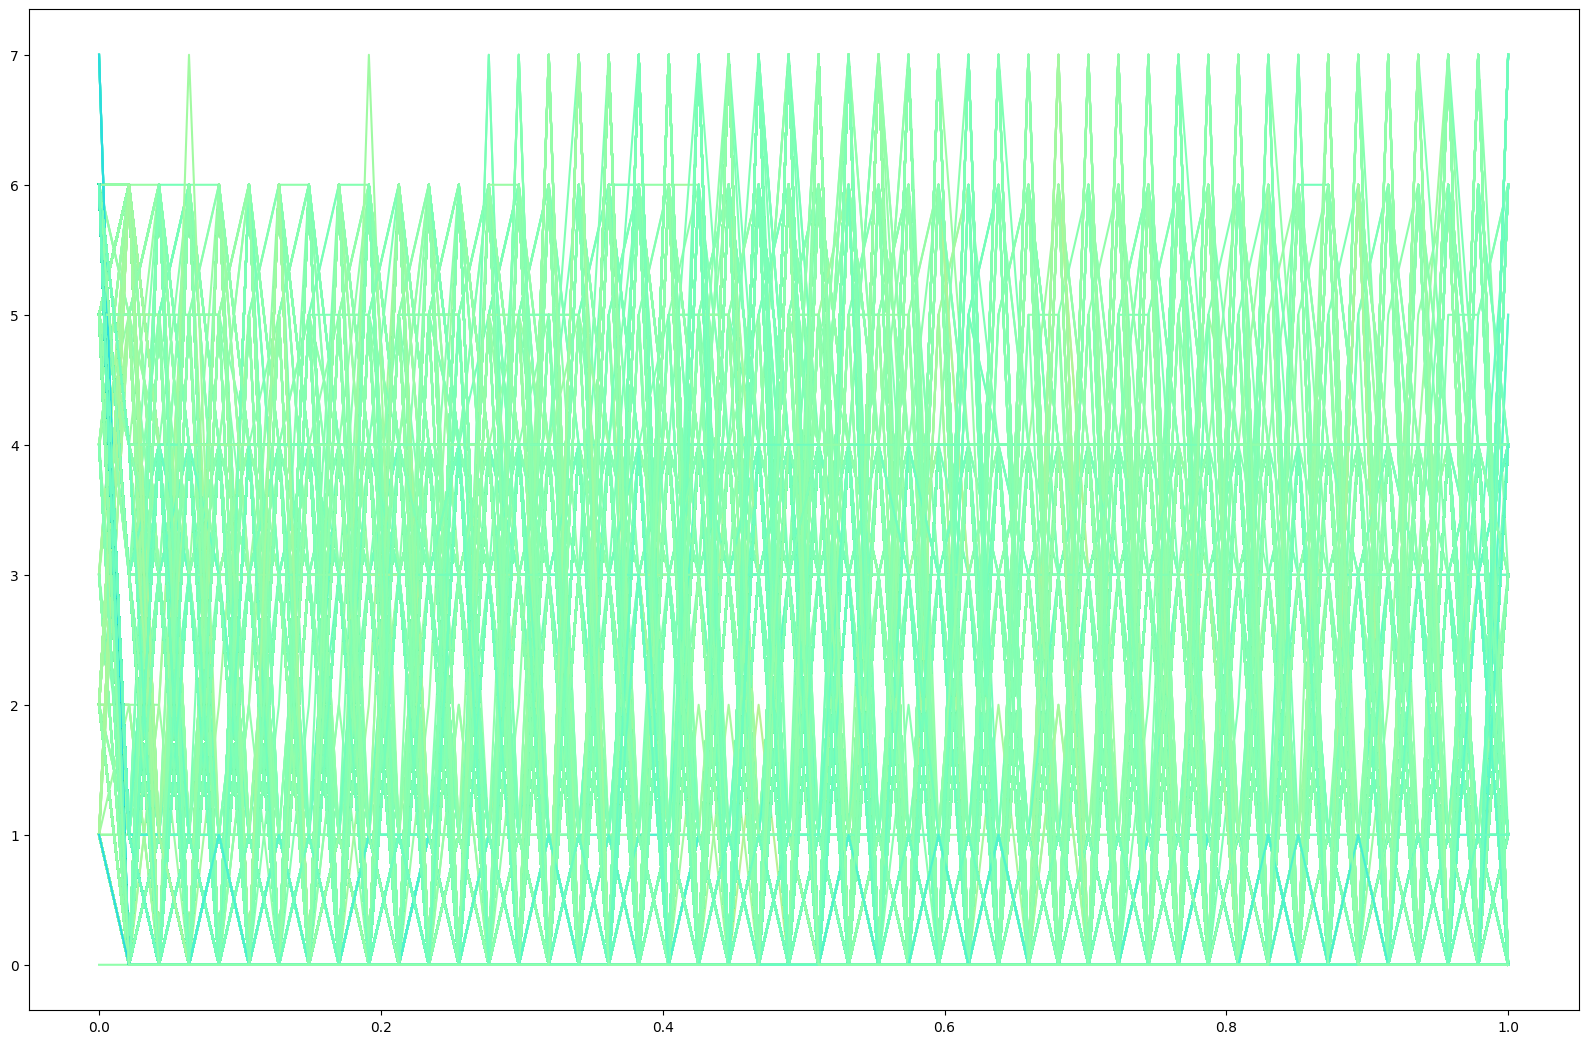

In [54]:
color = cm.rainbow(Anomaly_score)
fig = plt.figure(figsize = (20,13))
for i, c in zip(range(X.shape[0]), color):
    plt.plot(np.linspace(0,1,X.shape[1]), X[i], color = c)

### Récupération des ids des users ayant un score d'anomalie supérieur à 50%

In [49]:
anomaly_id = list(np.array(payers_id)[list(np.where(Anomaly_score>0.5)[0])])

### Construcion du DataFrame de prédiction

In [50]:
prediction = pd.DataFrame()
prediction["amplitude_id"] = df_hours["amplitude_id"]
prediction["is_anomaly"] = np.nan
prediction.loc[prediction["amplitude_id"].isin(anomaly_id), "is_anomaly"] = 1
prediction["is_anomaly"] = prediction["is_anomaly"].fillna(0)
prediction.head()

,amplitude_id,is_anomaly
20,454953384006,0.0
120,454959727343,0.0
121,454959768111,1.0
147,454961123802,0.0
152,454961419571,0.0


### Import des vraies valeurs

In [51]:
cancels = pd.read_csv("cancels.csv")
cancels["amplitude_id"] = cancels["amplitude_id"].astype(str)

### Construction du DataFrame vraies valeurs + prediction

In [52]:
true_prediction = pd.merge(cancels, prediction, on = "amplitude_id")
true_prediction.head()

,amplitude_id,is_rc_cancellation_event,is_anomaly
0,454953384006,0,0.0
1,454959727343,0,0.0
2,454961916385,0,0.0
3,454961955839,1,0.0
4,454962783634,0,0.0


### Performances du modèle

In [53]:
print(classification_report(true_prediction["is_rc_cancellation_event"], true_prediction["is_anomaly"]))
print(confusion_matrix(true_prediction["is_rc_cancellation_event"], true_prediction["is_anomaly"]))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      9943
           1       0.22      0.30      0.25      2748

    accuracy                           0.62     12691
   macro avg       0.50      0.50      0.50     12691
weighted avg       0.66      0.62      0.64     12691

[[7053 2890]
 [1937  811]]
